In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

In [2]:
# Load the competition datasets into Pandas DataFrame
train_proteins = pd.read_csv("~/Documents/amp-parkinsons-disease-progression-prediction/train_proteins.csv")
train_peptides = pd.read_csv("~/Documents/amp-parkinsons-disease-progression-prediction/train_peptides.csv")
train_clinical = pd.read_csv("~/Documents/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv")
supplemental_clinical = pd.read_csv("~/Documents/amp-parkinsons-disease-progression-prediction/supplemental_clinical_data.csv")

In [3]:
print(train_clinical.shape)
print(train_peptides.shape)
print(train_proteins.shape)
print(supplemental_clinical.shape)

(2615, 8)
(981834, 6)
(232741, 5)
(2223, 8)


In [4]:
train_clinical.head(10)

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On
5,55_18,55,18,7.0,13.0,38.0,0.0,On
6,55_24,55,24,16.0,9.0,49.0,0.0,On
7,55_30,55,30,14.0,13.0,49.0,0.0,On
8,55_36,55,36,17.0,18.0,51.0,0.0,On
9,55_42,55,42,12.0,20.0,41.0,0.0,On


In [93]:
train_peptides.head(20)

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.30
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.00
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.00
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.90
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.70
5,55_0,0,55,O00533,TLKIENVSYQDKGNYR,23216.50
6,55_0,0,55,O00533,VIAVNEVGR,170878.00
7,55_0,0,55,O00533,VMTPAVYAPYDVK,148771.00
8,55_0,0,55,O00533,VNGSPVDNHPFAGDVVFPR,55202.10
9,55_0,0,55,O00584,ELDLNSVLLK,27229.30


In [97]:
train_proteins.head(10)

,visit_id,visit_month,patient_id,UniProt,NPX,log10(NPX)
0,55_0,0,55,O00391,11254.30,9.328506
1,55_0,0,55,O00533,732430.00,13.504123
2,55_0,0,55,O00584,39585.80,10.586226
3,55_0,0,55,O14498,41526.90,10.634097
4,55_0,0,55,O14773,31238.00,10.349391
5,55_0,0,55,O14791,4202.71,8.343485
6,55_0,0,55,O15240,177775.00,12.088274
7,55_0,0,55,O15394,62898.20,11.049273
8,55_0,0,55,O43505,333376.00,12.717026
9,55_0,0,55,O60888,166850.00,12.024850


In [8]:
supplemental_clinical.head(10)

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,35_0,35,0,5.0,3.0,16.0,0.0,NaN
1,35_36,35,36,6.0,4.0,20.0,0.0,NaN
2,75_0,75,0,4.0,6.0,26.0,0.0,NaN
3,75_36,75,36,1.0,8.0,38.0,0.0,On
4,155_0,155,0,NaN,NaN,0.0,NaN,NaN
5,337_0,337,0,5.0,7.0,6.0,0.0,On
6,337_36,337,36,8.0,7.0,8.0,0.0,On
7,527_0,527,0,6.0,2.0,9.0,0.0,NaN
8,527_36,527,36,2.0,18.0,22.0,0.0,On
9,557_0,557,0,5.0,6.0,22.0,0.0,NaN


Observations: 
1) visit_id = patient_id + visit_month
2) NaN values will need to be dealt with. 
3) Visits seem to be made and recorded every 3 or 6 months for "clinical data", while in "supplemental data" a visit is recorded only every 36 months. 


In [9]:
# Determining the number of unique patients in the datasets.

clinical_patient_count = train_clinical['patient_id'].nunique()
print(f'There are {clinical_patient_count} number of unique patients in "train_clinical_data.csv"')

patient_count1 = train_peptides['patient_id'].nunique()
print(f'There are {patient_count1} number of unique patients in "train_peptides.csv"')

patient_count2 = train_proteins['patient_id'].nunique()
print(f'There are {patient_count2} number of unique patients in "train_proteins.csv"')
      
supplemental_patient_count = supplemental_clinical['patient_id'].nunique()
print(f'There are {supplemental_patient_count} number of unique patients in "supplemental_clinical_data.csv"')

There are 248 number of unique patients in "train_clinical_data.csv"
There are 248 number of unique patients in "train_peptides.csv"
There are 248 number of unique patients in "train_proteins.csv"
There are 771 number of unique patients in "supplemental_clinical_data.csv"


As we can see, all 248 clinical patients have their peptide and protein data recorded. 

In [10]:
# list all the unique patient_id
train_clinical['patient_id'].unique()

array([   55,   942,  1517,  1923,  2660,  3636,  3863,  4161,  4172,
        4923,  5027,  5036,  5178,  5645,  5742,  6054,  6211,  6420,
        7051,  7117,  7151,  7265,  7508,  7568,  7832,  7886,  8344,
        8699, 10053, 10138, 10174, 10541, 10715, 10718, 11459, 11686,
       11928, 12516, 12636, 12703, 12755, 12931, 13360, 13368, 13618,
       13804, 13852, 13968, 14035, 14124, 14242, 14270, 14344, 14450,
       14811, 15009, 15245, 15504, 15590, 16238, 16347, 16566, 16574,
       16778, 16931, 17154, 17201, 17414, 17727, 18183, 18204, 18553,
       18560, 19088, 20212, 20216, 20352, 20404, 20460, 20581, 20664,
       20707, 20791, 20792, 21126, 21537, 21729, 22126, 22623, 23175,
       23192, 23244, 23391, 23636, 24278, 24690, 24818, 24820, 24911,
       25562, 25739, 25750, 25827, 25911, 26005, 26104, 26210, 26809,
       27079, 27300, 27464, 27468, 27607, 27715, 27872, 27893, 27971,
       27987, 28327, 28342, 28818, 29313, 29417, 30119, 30155, 30416,
       30894, 30951,

In [11]:
# Look at all the available clincal data for one patient: patient_id = 55
train_clinical[train_clinical['patient_id']==55]

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On
5,55_18,55,18,7.0,13.0,38.0,0.0,On
6,55_24,55,24,16.0,9.0,49.0,0.0,On
7,55_30,55,30,14.0,13.0,49.0,0.0,On
8,55_36,55,36,17.0,18.0,51.0,0.0,On
9,55_42,55,42,12.0,20.0,41.0,0.0,On


In [12]:
# Look at all the available clincal data for another patient: patient_id = 942
train_clinical[train_clinical['patient_id']==942]

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
13,942_0,942,0,3.0,2.0,20.0,NaN,NaN
14,942_3,942,3,7.0,2.0,17.0,NaN,NaN
15,942_6,942,6,8.0,2.0,21.0,NaN,NaN
16,942_12,942,12,5.0,2.0,25.0,0.0,NaN
17,942_18,942,18,6.0,5.0,18.0,0.0,NaN
18,942_24,942,24,2.0,3.0,23.0,NaN,NaN
19,942_30,942,30,4.0,4.0,19.0,0.0,NaN
20,942_36,942,36,2.0,4.0,19.0,0.0,NaN
21,942_42,942,42,2.0,3.0,32.0,0.0,NaN
22,942_48,942,48,2.0,6.0,35.0,0.0,NaN


In [13]:
# Look at all the avaiable clincal data for another patient: patient_id = 1517
train_clinical[train_clinical['patient_id']==1517]

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
28,1517_0,1517,0,11.0,6.0,25.0,5.0,On
29,1517_6,1517,6,17.0,4.0,30.0,7.0,On
30,1517_12,1517,12,20.0,11.0,32.0,5.0,On
31,1517_18,1517,18,23.0,14.0,25.0,5.0,On
32,1517_24,1517,24,19.0,11.0,28.0,3.0,On
33,1517_30,1517,30,20.0,15.0,39.0,10.0,Off
34,1517_36,1517,36,20.0,17.0,31.0,8.0,On
35,1517_42,1517,42,15.0,13.0,37.0,4.0,On
36,1517_48,1517,48,20.0,18.0,40.0,6.0,Off
37,1517_60,1517,60,19.0,18.0,39.0,10.0,Off


I notice a lot of NaN values in the previous patient data, especially in 'clinical_state_on_medication' column, so let's count all the NaN values in each column.

In [14]:
train_clinical.isna().sum()

visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                   1
updrs_2                                   2
updrs_3                                  25
updrs_4                                1038
upd23b_clinical_state_on_medication    1327
dtype: int64

Out of 2615 entries for each column, "upd23b_clinical_state_on_medication" has over 50% of of the values as NaN. Since it's indication whether a patient is either "on" or "off" medication, there is no straight forward way to interpolate the missing values. I'm going to drop the column entirely, especially considering that the testing data will not have any medication data. 

In [15]:
# counting the number of unique scores in 'updrs_4' and their occurances.
train_clinical['updrs_4'].value_counts()

0.0     961
3.0     107
4.0      86
2.0      83
5.0      82
1.0      64
6.0      55
7.0      40
8.0      27
9.0      22
10.0     17
11.0      8
13.0      7
14.0      7
12.0      5
16.0      3
20.0      1
15.0      1
17.0      1
Name: updrs_4, dtype: int64

In [16]:
# counting the number of unique scores for 'clinical state on medication' and their occurances.

train_clinical['upd23b_clinical_state_on_medication'].value_counts()

On     775
Off    513
Name: upd23b_clinical_state_on_medication, dtype: int64

In [17]:
# drop the "medication status" column (due to over 50% NaN values), keep a copy of the original
# for later access. 
train_clinical_copy = train_clinical.copy()

train_clinical.drop('upd23b_clinical_state_on_medication', axis=1, inplace=True)


In [18]:
train_clinical

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,55_0,55,0,10.0,6.0,15.0,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0
4,55_12,55,12,10.0,10.0,41.0,0.0
...,...,...,...,...,...,...,...
2610,65043_48,65043,48,7.0,6.0,13.0,0.0
2611,65043_54,65043,54,4.0,8.0,11.0,1.0
2612,65043_60,65043,60,6.0,6.0,16.0,1.0
2613,65043_72,65043,72,3.0,9.0,14.0,1.0


In [19]:
# and use interpolate() on the rest of the dataset.

train_clinical['updrs_1'].interpolate(method='linear', limit_direction='both', inplace=True)
train_clinical['updrs_2'].interpolate(method='linear', limit_direction='both', inplace=True)
train_clinical['updrs_3'].interpolate(method='linear', limit_direction='both', inplace=True)
train_clinical['updrs_4'].interpolate(method='linear', limit_direction='both', inplace=True)

In [20]:
# no more NaN values remaining. 

train_clinical.isna().sum()

visit_id       0
patient_id     0
visit_month    0
updrs_1        0
updrs_2        0
updrs_3        0
updrs_4        0
dtype: int64

In [94]:
# let's look at the other datasets. 

train_peptides.isna().sum()

visit_id            0
visit_month         0
patient_id          0
UniProt             0
Peptide             0
PeptideAbundance    0
dtype: int64

In [95]:
train_proteins.isna().sum()

visit_id       0
visit_month    0
patient_id     0
UniProt        0
NPX            0
log10(NPX)     0
dtype: int64

In [96]:
supplemental_clinical.isna().sum()

visit_id       0
patient_id     0
visit_month    0
updrs_1        0
updrs_2        0
updrs_3        0
updrs_4        0
source         0
dtype: int64

In [24]:
# we'll also drop the 'medication' column and interpolate the rest using the same method.

supplemental_clinical.drop('upd23b_clinical_state_on_medication', axis=1, inplace=True)


In [25]:
supplemental_clinical['updrs_1'].interpolate(method='linear', limit_direction='both', inplace=True)
supplemental_clinical['updrs_2'].interpolate(method='linear', limit_direction='both', inplace=True)
supplemental_clinical['updrs_3'].interpolate(method='linear', limit_direction='both', inplace=True)
supplemental_clinical['updrs_4'].interpolate(method='linear', limit_direction='both', inplace=True)

In [26]:
supplemental_clinical.isnull().sum()

visit_id       0
patient_id     0
visit_month    0
updrs_1        0
updrs_2        0
updrs_3        0
updrs_4        0
dtype: int64

In [27]:
cols = ['visit_month','updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']
train_clinical[cols].describe().T

,count,mean,std,min,25%,50%,75%,max
visit_month,2615.0,31.190822,25.199053,0.0,10.5,24.0,48.0,108.0
updrs_1,2615.0,7.109560,5.525134,0.0,3.0,6.0,10.0,33.0
updrs_2,2615.0,6.742256,6.322507,0.0,1.0,5.0,10.0,40.0
updrs_3,2615.0,19.453537,14.958571,0.0,6.0,19.0,29.0,86.0
updrs_4,2615.0,1.804398,2.802758,0.0,0.0,0.0,3.0,20.0


In [28]:
supplemental_clinical[cols].describe().T

,count,mean,std,min,25%,50%,75%,max
visit_month,2223.0,12.910481,13.060532,0.0,0.0,6.0,24.0,36.0
updrs_1,2223.0,5.790148,4.296143,0.0,3.0,5.0,8.0,27.0
updrs_2,2223.0,6.618534,4.888636,0.0,3.0,6.0,10.0,34.0
updrs_3,2223.0,22.930274,12.336572,0.0,14.0,22.0,31.0,72.0
updrs_4,2223.0,0.956365,1.798018,0.0,0.0,0.0,1.2,12.0


Max follow-up for patients in "clinical Data" is 108 months, and max follow-up for patients in "supplemental data" is 36 months.

Let's see how many of the 'clinical' patients are followed up for 56 months (mean + 1 std) or more, and how many of the 'supplemental' patients are followed up for 36 months (max).

In [29]:
months_followed = 56
unique_pt_count = train_clinical[train_clinical['visit_month']>=months_followed]['patient_id'].nunique()

In [30]:
unique_pt_count_suppl = supplemental_clinical[supplemental_clinical['visit_month']>=36]['patient_id'].nunique()

In [31]:
print(f'{unique_pt_count/clinical_patient_count*100:.2f}% in the clinical data are follwed up for 56 months or more.')
print(f'{unique_pt_count_suppl/supplemental_patient_count*100:.2f}% in the supplemental data are follwed up for 36 months.')

68.95% in the clinical data are follwed up for 56 months or more.
33.46% in the supplemental data are follwed up for 36 months.


In [32]:
# label the source of data before combining them.
train_clinical['source'] = 'Clinical Data'
supplemental_clinical['source'] = 'Supplemental Data'

combined_data = pd.concat([train_clinical, supplemental_clinical],ignore_index=True)

In [33]:
combined_data

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,source
0,55_0,55,0,10.0,6.0,15.0,0.0,Clinical Data
1,55_3,55,3,10.0,7.0,25.0,0.0,Clinical Data
2,55_6,55,6,8.0,10.0,34.0,0.0,Clinical Data
3,55_9,55,9,8.0,9.0,30.0,0.0,Clinical Data
4,55_12,55,12,10.0,10.0,41.0,0.0,Clinical Data
...,...,...,...,...,...,...,...,...
4833,65382_0,65382,0,4.5,8.5,0.0,0.0,Supplemental Data
4834,65405_0,65405,0,5.0,16.0,31.0,0.0,Supplemental Data
4835,65405_5,65405,5,7.5,11.0,57.0,0.0,Supplemental Data
4836,65530_0,65530,0,10.0,6.0,24.0,0.0,Supplemental Data


In [34]:
# check the total number of patients in the combined data. 
combined_data['patient_id'].nunique()

1019

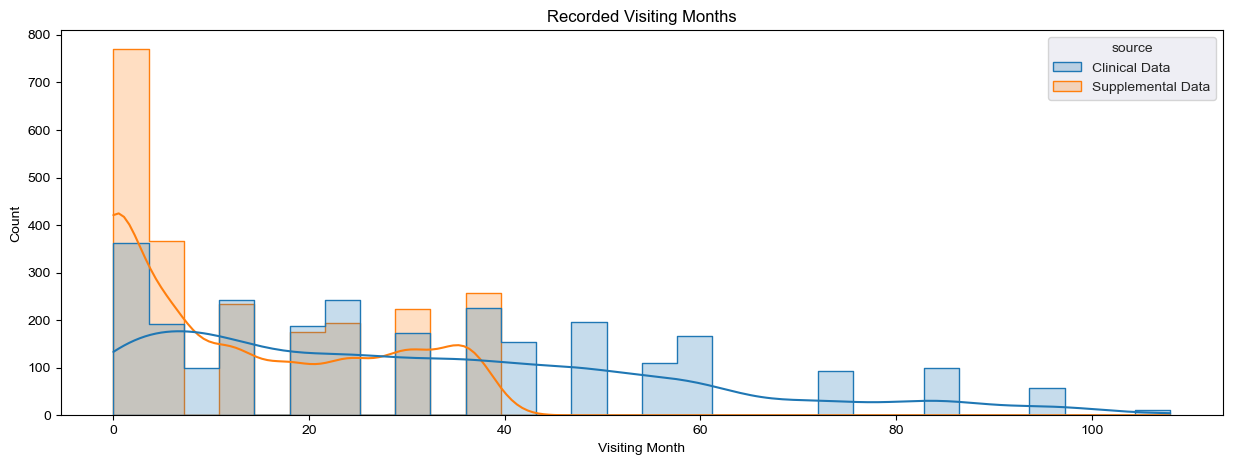

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
sns.set_style('dark')
sns.histplot(data=combined_data, x='visit_month', hue='source', kde=True, ax=ax, element='step')
ax.set_title('Recorded Visiting Months')
ax.set_ylabel('Count')
ax.set_xlabel('Visiting Month');

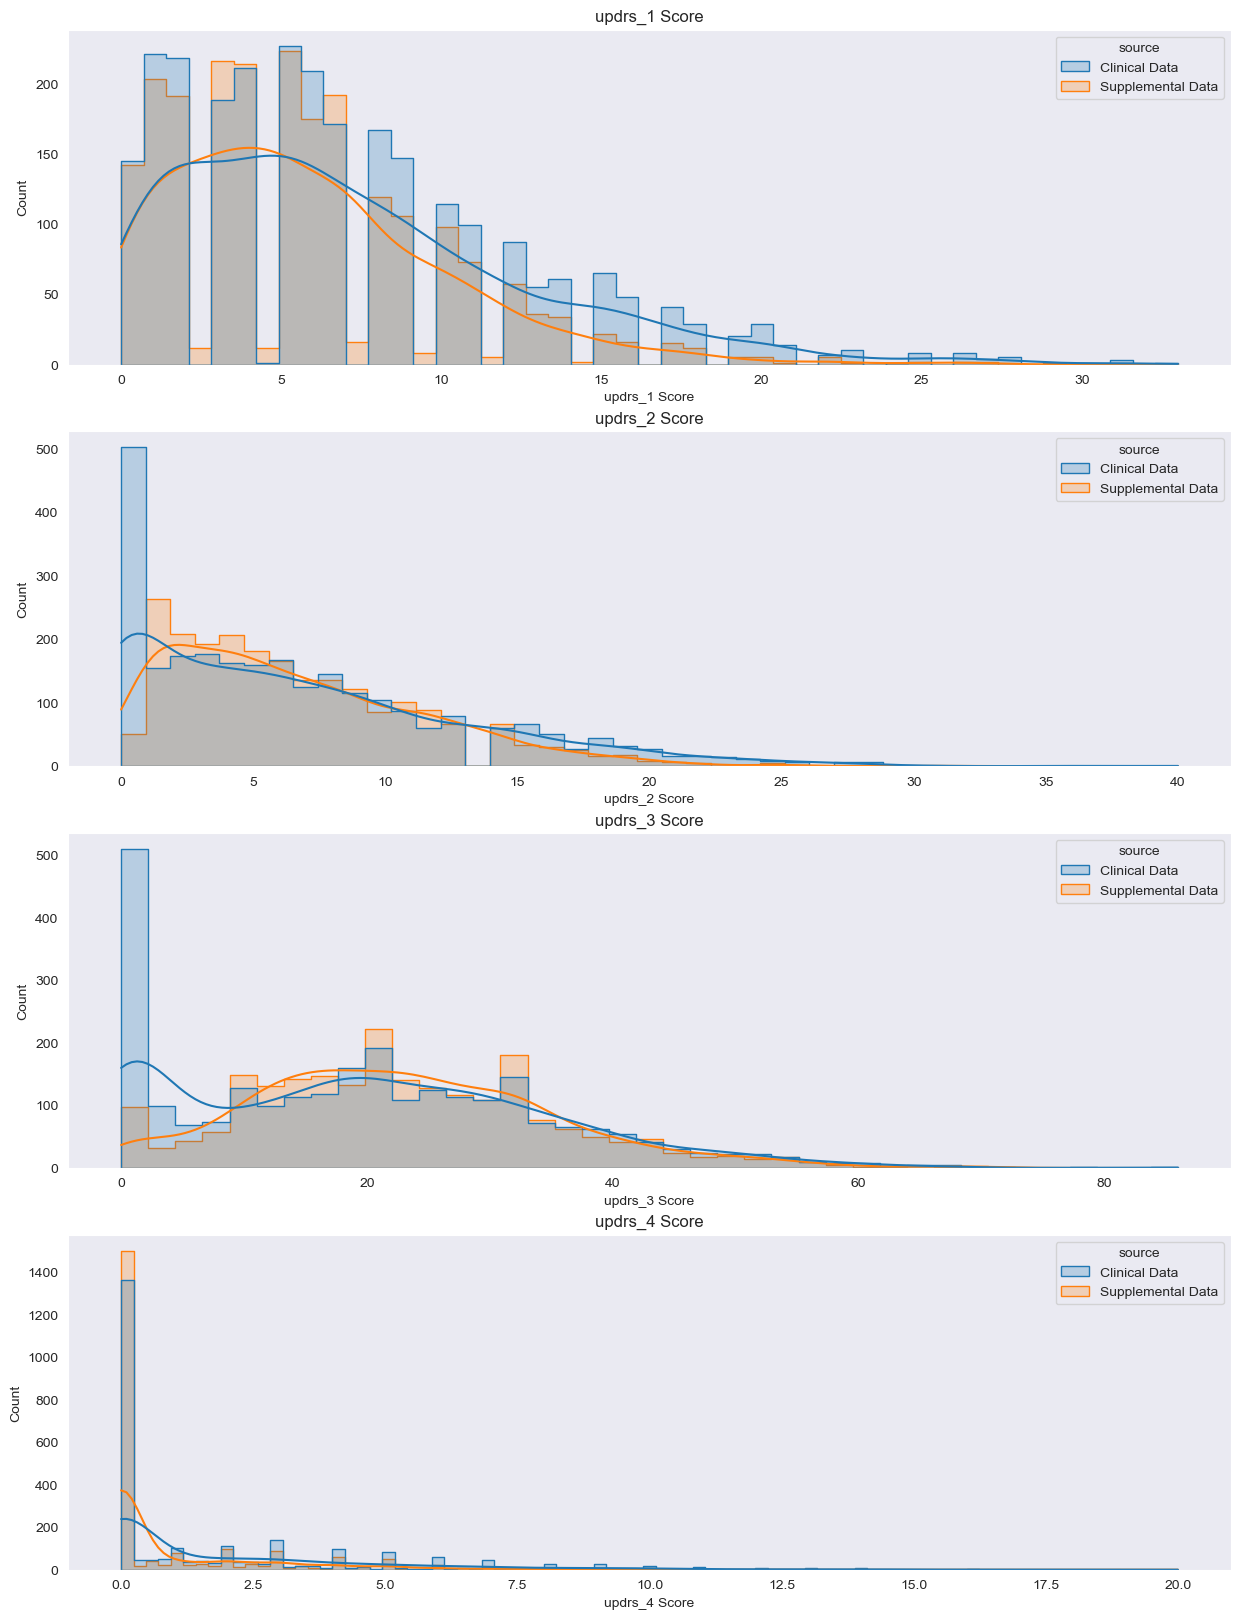

In [36]:
cols = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(15,20))
sns.set_style('dark')

for x, col in enumerate(cols):
    ax = axs[x]
    sns.histplot(data=combined_data, x=col, hue='source', kde=True, ax=ax, element='step')
    ax.set_title(f'{col} Score')
    ax.set_ylabel('Count')
    ax.set_xlabel(f'{col} Score')

UPDRS_1 and UPDRS_4 are similarly distributed across clincal data and supplemental data, while UPDRS_2 and UPDRS_3 scores are not. UPDRS_2 and UPDRS_3 scores have a much higher percentage of '0'. Since the two datasets are so different (in both score distribution, duration followed, and frequency of follow-up visits), should we be combining them and training a model on the combined data? My intution tells me that a model should only be trained on the "clinical" dataset.

In [37]:
# taking a quick look at the protein data
train_proteins.describe().T

,count,mean,std,min,25%,50%,75%,max
visit_month,232741.0,2.609920e+01,2.287472e+01,0.0000,6.0,24.0,48.0,108.0
patient_id,232741.0,3.259388e+04,1.860848e+04,55.0000,16566.0,29313.0,49995.0,65043.0
NPX,232741.0,2.712077e+06,2.224155e+07,84.6082,29464.4,113556.0,563894.0,613851000.0


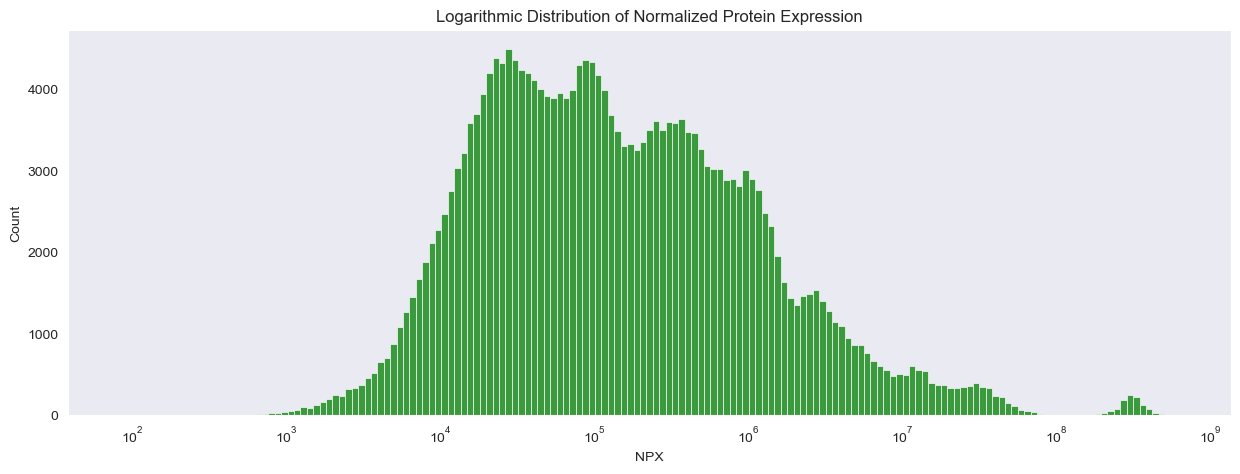

In [38]:
data = train_proteins['NPX']
fig, ax = plt.subplots(ncols=1,nrows=1, figsize=(15,5))
sns.histplot(data, ax=ax, log_scale=True, color='g')
ax.set_title('Logarithmic Distribution of Normalized Protein Expression');

In [39]:
# peptide data
train_peptides.describe().T

,count,mean,std,min,25%,50%,75%,max
visit_month,981834.0,26.105061,2.291390e+01,0.0000,6.00,24.0,48.00,108.0
patient_id,981834.0,32603.465361,1.860593e+04,55.0000,16566.00,29313.0,49995.00,65043.0
PeptideAbundance,981834.0,642890.245933,3.377989e+06,10.9985,28174.25,74308.3,221338.75,178752000.0


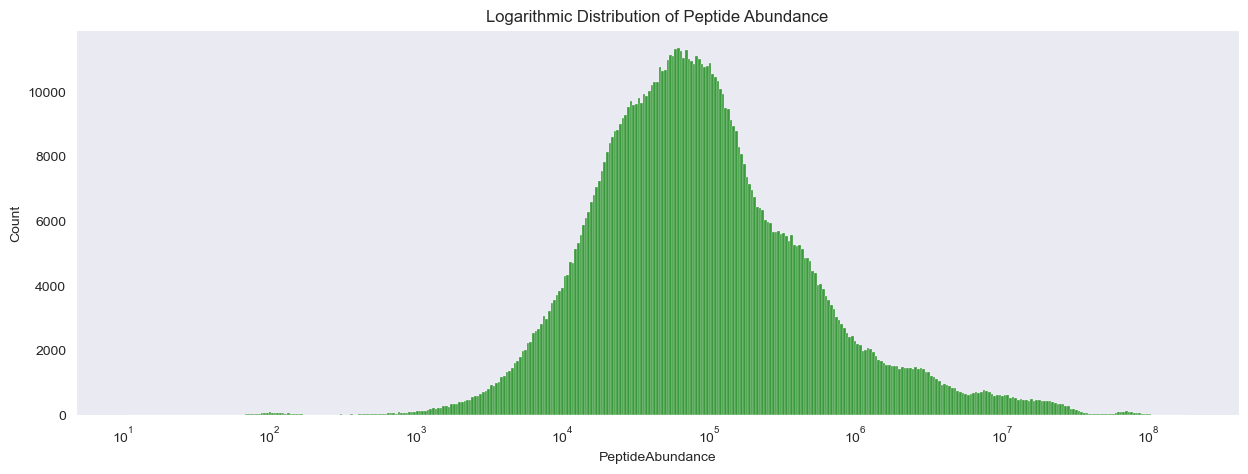

In [40]:
data = train_peptides['PeptideAbundance']
fig, ax = plt.subplots(ncols=1,nrows=1, figsize=(15,5))
sns.histplot(data, ax=ax, log_scale=True, color='g')
ax.set_title('Logarithmic Distribution of Peptide Abundance');

c:\Users\13392\miniconda3\envs\cn_ml_course\Lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


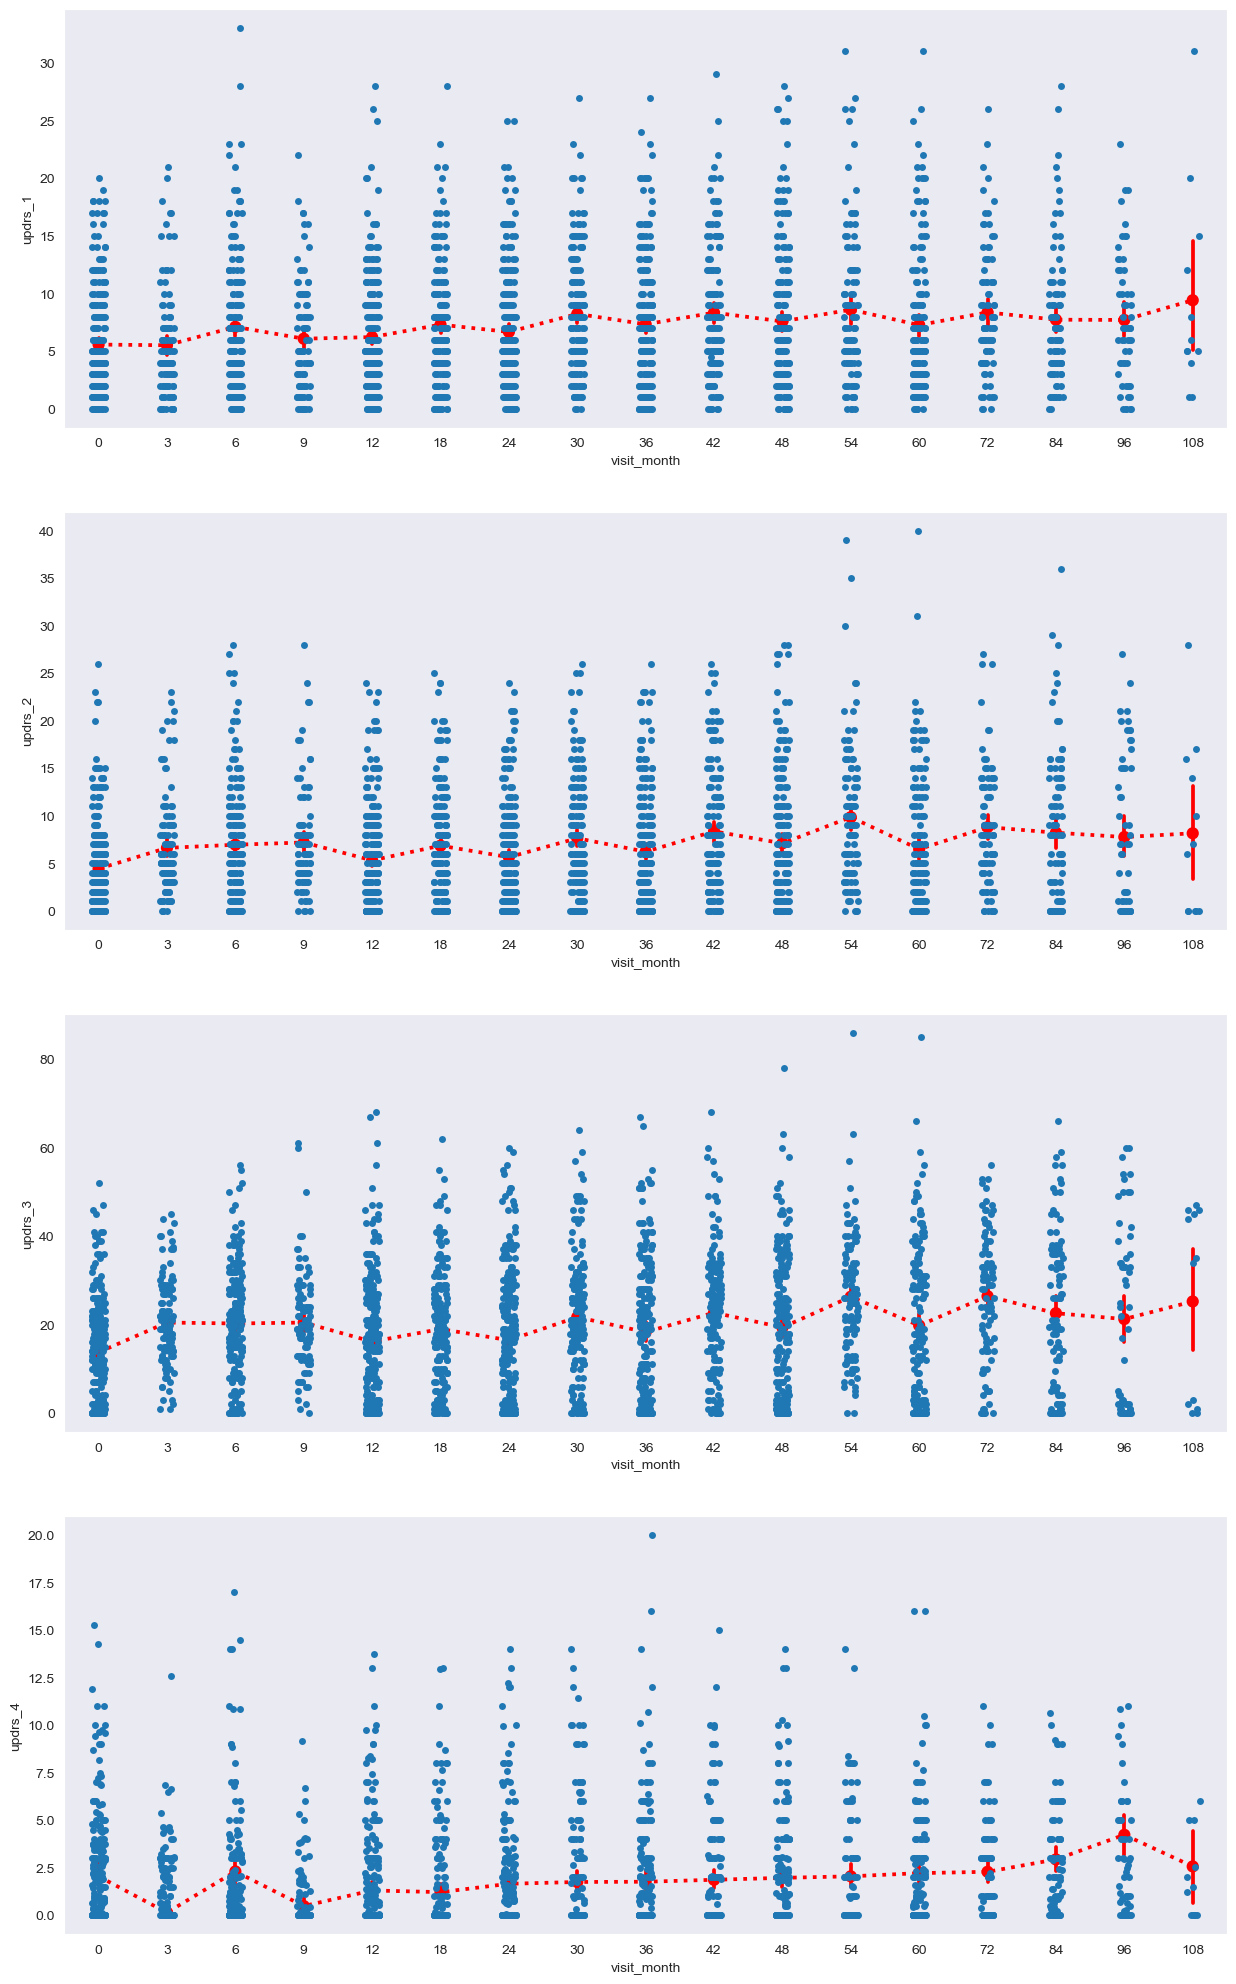

In [79]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(15,25))
cols = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']
#axs = axs.flatten()

for i, col in enumerate(cols):
    ax=axs[i]
    sns.stripplot(data=train_clinical, x='visit_month', y=col, ax=ax)
    sns.pointplot(data=train_clinical_copy, x='visit_month', y=col, color='r', ax=ax, linestyles=':')


The data trend is not overly encouraging, as it shows relatively little disease progression trend, as one would expect with Parkinson's, i.e. worsening symptoms over time showing increasing UPDRS scores. There is only a slight upward trend in UPDRS_1, _2, and _3. 

What if we combine all four UPDRS scores?

In [81]:
train_clinical['updrs_total'] = train_clinical['updrs_1']+train_clinical['updrs_2']+train_clinical['updrs_3']+train_clinical['updrs_4']

In [82]:
train_clinical.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,source,updrs_total
0,55_0,55,0,10.0,6.0,15.0,0.0,Clinical Data,31.0
1,55_3,55,3,10.0,7.0,25.0,0.0,Clinical Data,42.0
2,55_6,55,6,8.0,10.0,34.0,0.0,Clinical Data,52.0
3,55_9,55,9,8.0,9.0,30.0,0.0,Clinical Data,47.0
4,55_12,55,12,10.0,10.0,41.0,0.0,Clinical Data,61.0


<Axes: xlabel='visit_month', ylabel='updrs_total'>

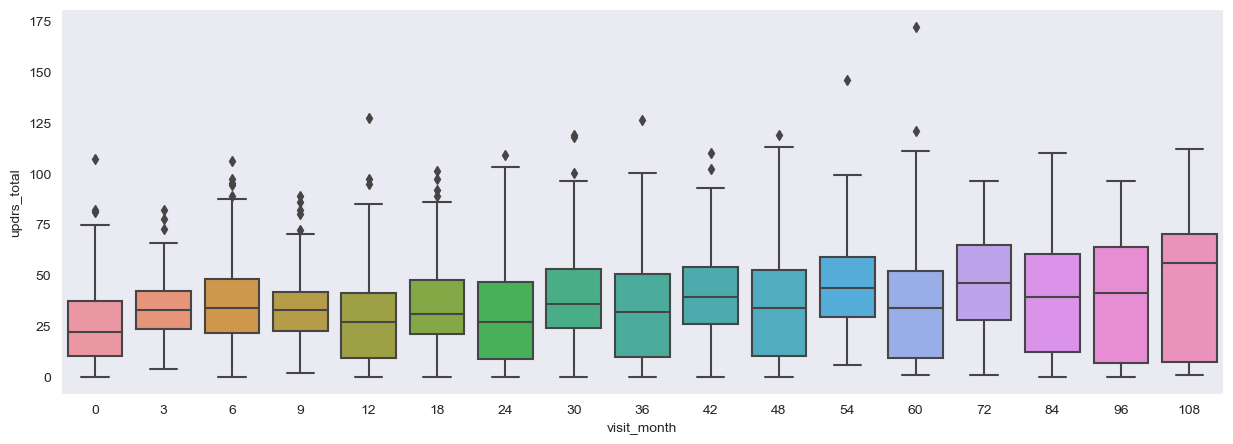

In [89]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
sns.boxplot(data=train_clinical, x='visit_month', y='updrs_total', ax=ax)

Again, there is only a very slight upward trend of the total UPDRS score over 108 months of follow-up.

Let's now look at the Protein Data. We'll convert NPX to natural log since the dataset range is too wide otherwise.

<Axes: xlabel='visit_month', ylabel='log(NPX)'>

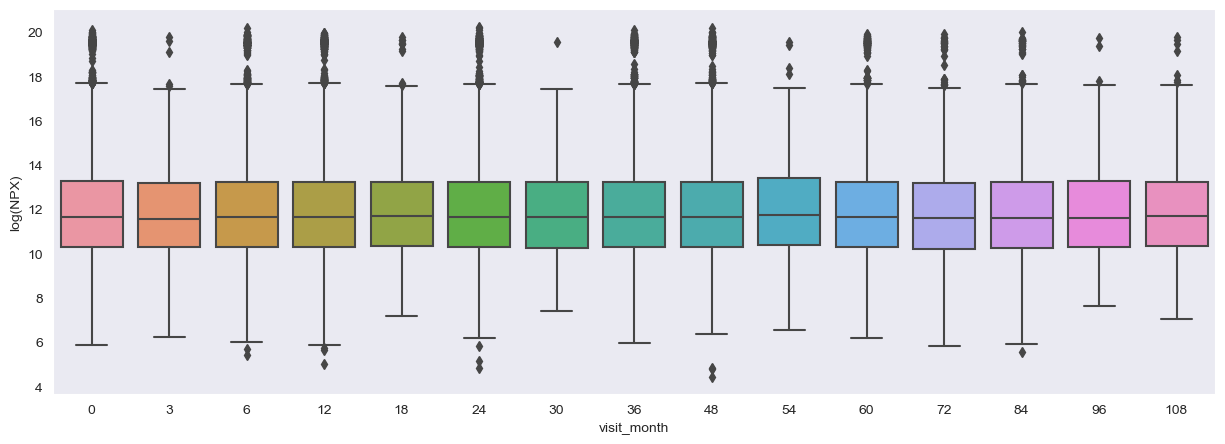

In [98]:
train_proteins['log(NPX)'] = np.log(train_proteins['NPX'])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))

sns.boxplot(data=train_proteins, x='visit_month', y='log(NPX)', ax=ax)

This likely indicates that the total protein expressed (NPX) shows very little correlation with disease progression, but maybe certain types of peptides and their amounts can be telling? Let's build a correlation matrix to have a closer look!